### Import Libraries and Define Functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import math

In [2]:
def print_nulls(df):
    
    out = df.isnull().sum()*100/df.isnull().isnull().count()
    
    pd.set_option('display.max_rows', len(out))
    print(out)
    pd.reset_option('display.max_rows')

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column)
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 95th percentile
    plt.show()

### Load the Dataset

In [32]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  houseprices
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [34]:
len(df.select_dtypes(include='number').columns)

38

In [6]:
# Moved the target variable to first column for convience. dropped id

df = df[['saleprice', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'wooddecksf', 'openporchsf', 'enclosedporch',
       'threessnporch', 'screenporch', 'poolarea', 'poolqc', 'fence',
       'miscfeature', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition']]

### Missing Values

According to our metadata, for many of our categorical values null values indiciate that feature was not present in the home for sale. This makes filling those values easy.

In [7]:
print_nulls(df)

saleprice         0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfinsf1        0.000000
bsmtfintype2      2.602740
bsmtfinsf2        0.000000
b

In [8]:
# Simple nulls = feature not present 

df['alley'].fillna('no_alley', inplace=True)

df['fence'].fillna('no_fence', inplace=True)

df['poolqc'].fillna('no_pool', inplace=True)

df['fireplacequ'].fillna('no_fireplace', inplace=True)

# Garage variables
mask = np.where(df['garagecars'] == 0)[0]
for var in ['garagetype', 'garagefinish', 'garagequal', 'garagecond']:
    df.loc[mask, var] = 'no_garage'

# 'garageyrblt' presents a problem since there is no straightforward to fill that value
# it is only moderatly correlated to 'saleprice' I'll drop that column for now
df.drop('garageyrblt', axis=1, inplace=True)

# masonry variables
df['masvnrtype'].fillna('None', inplace=True)

df['masvnrarea'].fillna(0, inplace=True)


# Basement variables 

# These observations each contain missing basement values. 948 is missing exposure 
# and 333 is missing the 2nd basement finish type
# keep these values in mind for imputation later
df.drop([948, 333])

# for the rest of the values
for var in ['bsmtqual','bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2']:
    df[var].fillna('no_basement', inplace=True)
    
    
# drop this feature as noise
df.drop(['miscfeature', 'miscval'], axis=1, inplace=True)

# There is a single observation with a missing value for 'electrical', I'll drop that observation
df.drop(np.where(df['electrical'].isnull())[0], inplace=True)


# Lotfrontage contains a significant number of missing values. A little exploration reveals that these are not
# likely homes with no frontage. However it is also not strongly correlated with the target variable. For now
# I will drop it 

df.drop('lotfrontage', axis=1, inplace=True)

In [9]:
print_nulls(df)

saleprice        0.0
mssubclass       0.0
mszoning         0.0
lotarea          0.0
street           0.0
alley            0.0
lotshape         0.0
landcontour      0.0
utilities        0.0
lotconfig        0.0
landslope        0.0
neighborhood     0.0
condition1       0.0
condition2       0.0
bldgtype         0.0
housestyle       0.0
overallqual      0.0
overallcond      0.0
yearbuilt        0.0
yearremodadd     0.0
roofstyle        0.0
roofmatl         0.0
exterior1st      0.0
exterior2nd      0.0
masvnrtype       0.0
masvnrarea       0.0
exterqual        0.0
extercond        0.0
foundation       0.0
bsmtqual         0.0
bsmtcond         0.0
bsmtexposure     0.0
bsmtfintype1     0.0
bsmtfinsf1       0.0
bsmtfintype2     0.0
bsmtfinsf2       0.0
bsmtunfsf        0.0
totalbsmtsf      0.0
heating          0.0
heatingqc        0.0
centralair       0.0
electrical       0.0
firstflrsf       0.0
secondflrsf      0.0
lowqualfinsf     0.0
grlivarea        0.0
bsmtfullbath     0.0
bsmthalfbath 

### Variable consolidation and other fixes

In [10]:
# The subclass variable has sparse levels, some can be combined into others. It also needs to be remapped

df['mssubclass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      57
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: mssubclass, dtype: int64

In [11]:
# consolidate 
mask = (df['mssubclass'] == 40) & (df['yearbuilt'] >= 1946)
df.loc[mask, 'mssubclass'] = 20

mask = (df['mssubclass'] == 40) & (df['yearbuilt'] <= 1945)
df.loc[mask, 'mssubclass'] = 30

mask = df['mssubclass'] == 45
df.loc[mask, 'mssubclass'] = 50


In [12]:
subclass_map = { 20 : '1_story_1946_forward'
        , 30 : '1_story_1945_backward'
        , 50 : '1.5_story'
        , 60 : '2_story_1946_forward'
        , 70 : '2_story_1945_backward'
        , 75 : '2.5_story'
        , 80 : 'split_level'
        , 85 : 'split_foyer'
        , 90 : 'duplex'
       , 120 : '1_story_planned'
       , 160 : '2_story_planned_'
       , 180 : 'planned_multilevel'
       , 190 : '2_family_conversion'
               }

df['mssubclass'].replace(subclass_map, inplace=True)

In [13]:
# consolidate outdoor space variables
df['outdoor_space'] = df['wooddecksf'] + df['openporchsf']
+ df['enclosedporch'] + df['threessnporch'] + df['screenporch']

# There are many possible ways to group the square footage. Here I will begin with two groupings and see
# how they perform in modeling.
df['interior_square_feet'] = df['totalbsmtsf'] + df['grlivarea']

# Combine the bathrooms variables
df['total_bathrooms'] = df['bsmtfullbath'] + df['bsmthalfbath']/2 + df['fullbath'] + df['halfbath']/2

# Drop the component variables
df.drop(['totalbsmtsf', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'grlivarea', 'firstflrsf', 'secondflrsf'
         , 'lowqualfinsf',  'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch'
         , 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath'], axis=1, inplace=True)

In [14]:
# convert year built to age
df['age'] = 2010 - df['yearbuilt']
df.drop('yearbuilt', axis=1, inplace=True)

In [15]:
# drop garage cars in favor of garage area
df.drop('garagecars', axis=1, inplace=True)

In [16]:
# bedrooms are counted within the total rooms variable
df.drop('bedroomabvgr', axis=1, inplace=True)

## EDA

In [17]:
# create masks for the columns by type
conts = df.select_dtypes(include='number').columns
cats = df.select_dtypes(include='object').columns

### Visualizations
For the continueous variables I will produce a correlation heatmap as well as a histogram and box plot for each. Boxplots whiksers are set to the inner 95th percentile.

For the categorical variables I will produce a visualization of the number of observations for each category as well visualize the mean saleprice of each category.

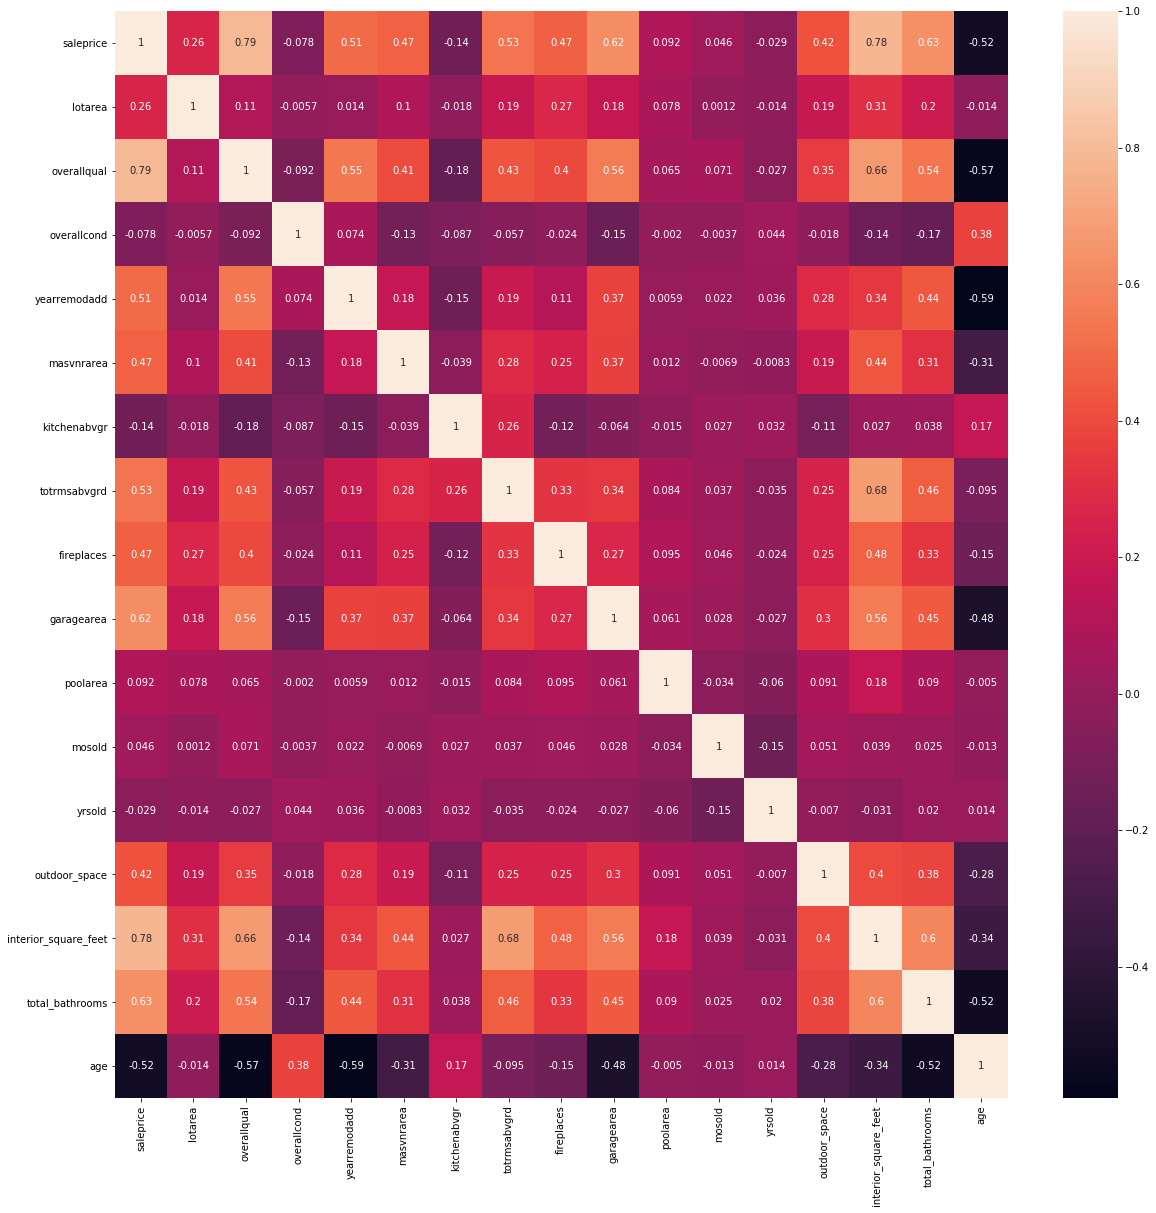

In [18]:
# Plot a heatmap of correlation
corr_map = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)

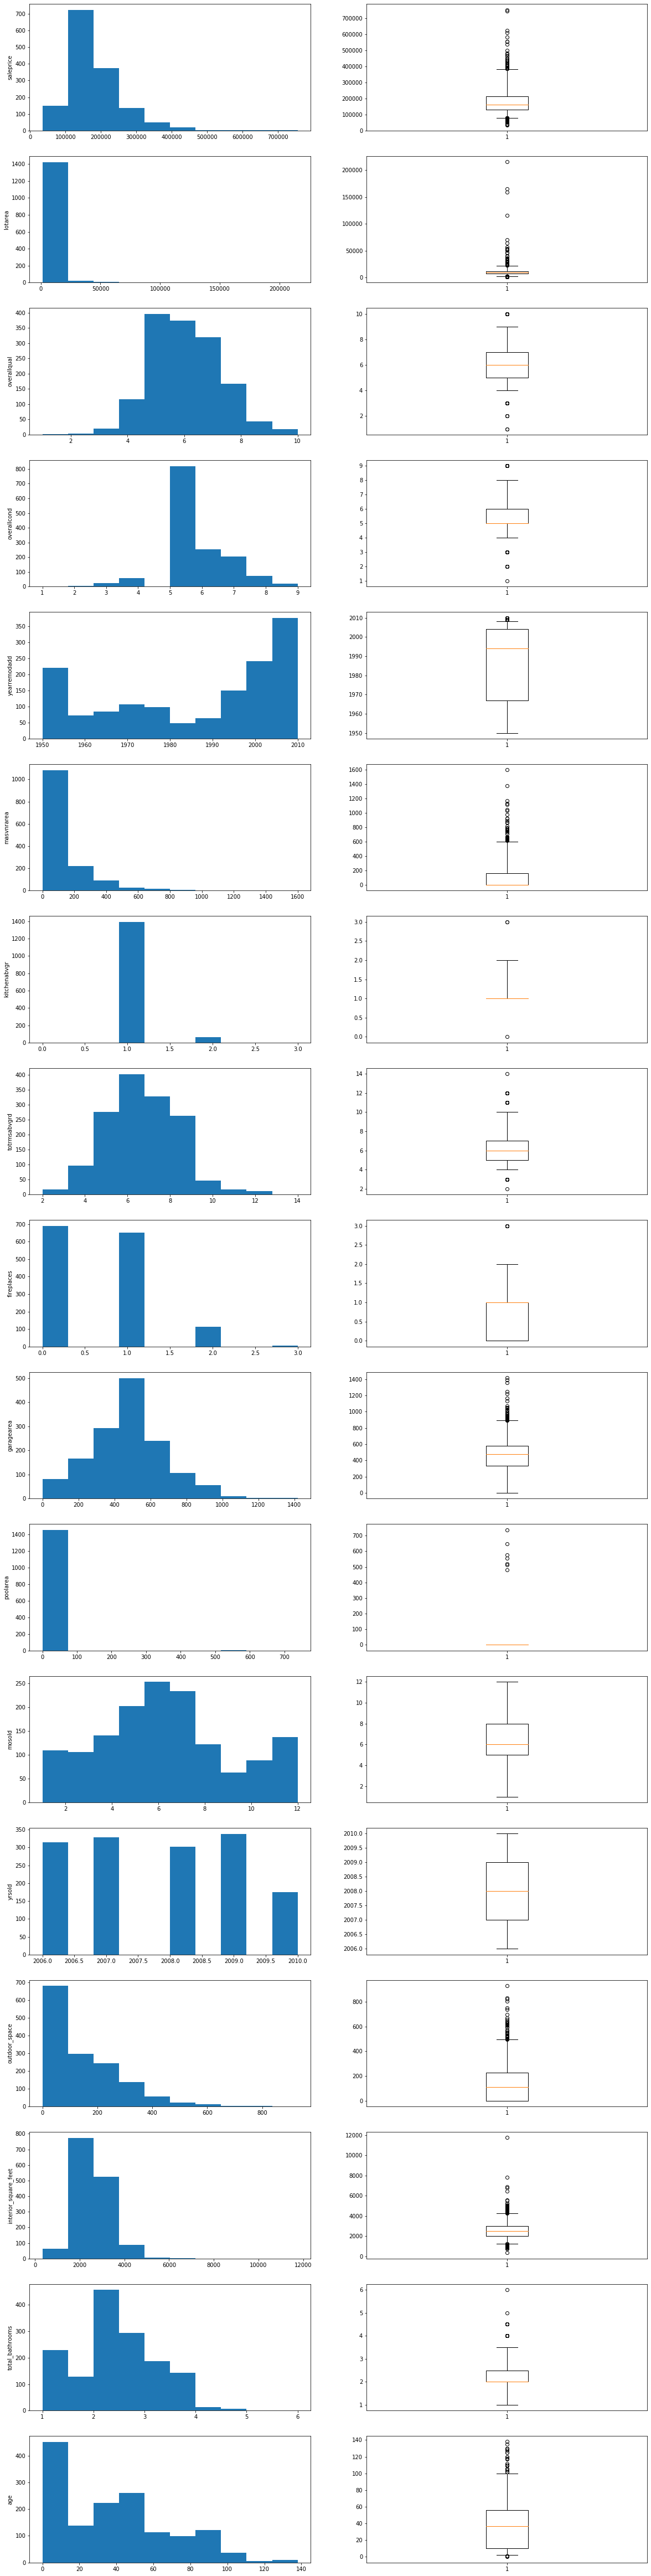

In [19]:

plot_hist_boxplot(df.select_dtypes(include='number'))

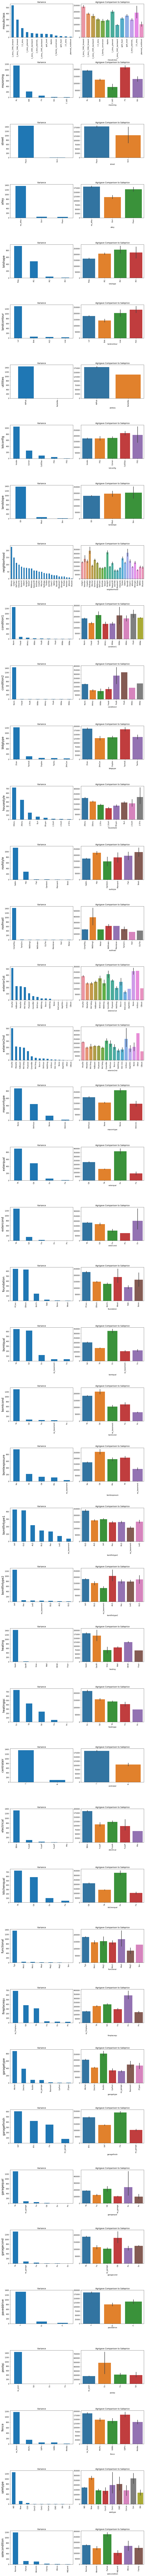

In [20]:
plt.figure(figsize=(12, len(cats)*5))
for i, feature in enumerate(cats):
    plt.subplot(len(cats), 2, (i+1)*2-1)
    df[feature].value_counts().plot(kind='bar')
    plt.ylabel(feature, size='xx-large')
    plt.title('Variance')
    plt.xlabel('')
    plt.xticks(rotation=90)
    
    
    plt.subplot(len(cats), 2, (i+1)*2)
    sns.barplot(x=df[feature], y=df['saleprice'])
    plt.ylabel('')
    plt.title('Agrigave Comparison to Saleprice')
    plt.xticks(rotation=90)
plt.tight_layout(pad=0.3)
plt.show()

### Target Variable

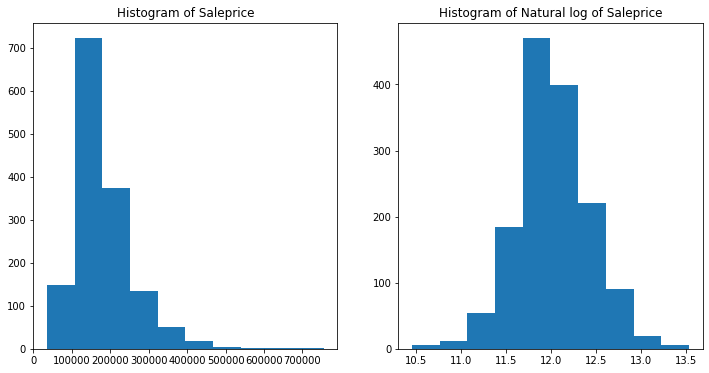

In [21]:
## The target variable is heavily skewed to the right
# A simple log transformation should help
log_sale = np.log(df['saleprice'])
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Histogram of Saleprice')
plt.hist(df['saleprice'])

plt.subplot(1, 2, 2)
plt.title('Histogram of Natural log of Saleprice')
plt.hist(log_sale)
plt.show()

In [22]:
# Which variables are most strongly correlated with saleprice?
df.corr()['saleprice'].sort_values(ascending=False)

saleprice               1.000000
overallqual             0.791069
interior_square_feet    0.779104
total_bathrooms         0.631809
garagearea              0.623423
totrmsabvgrd            0.533779
yearremodadd            0.507430
masvnrarea              0.472606
fireplaces              0.466968
outdoor_space           0.424241
lotarea                 0.263837
poolarea                0.092397
mosold                  0.046380
yrsold                 -0.028907
overallcond            -0.077924
kitchenabvgr           -0.135935
age                    -0.523273
Name: saleprice, dtype: float64

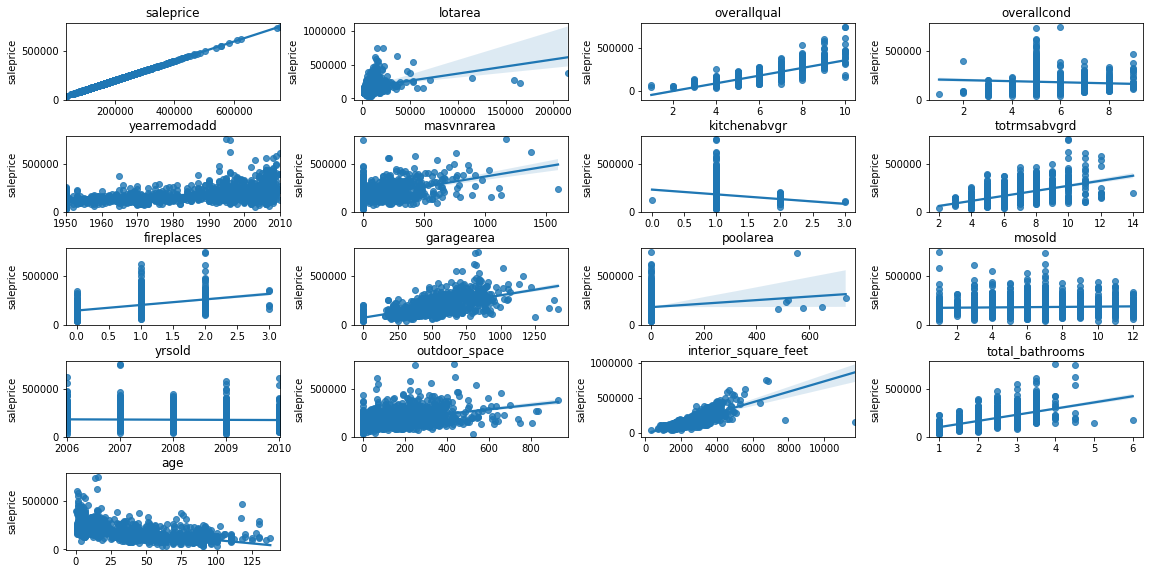

In [23]:
plt.figure(figsize=(16, len(conts)))
for i, feature in enumerate(conts):
    x = df[feature]
    y = df['saleprice']
    plt.subplot(math.ceil(len(cats)/4), 4, i+1)
    sns.regplot(x=x, y=y)
    plt.title(feature)
    plt.xlabel('')
plt.tight_layout(pad=0.3)
plt.suptitle('')
plt.show()

Text(0.5, 1.0, 'Outliers Removed')

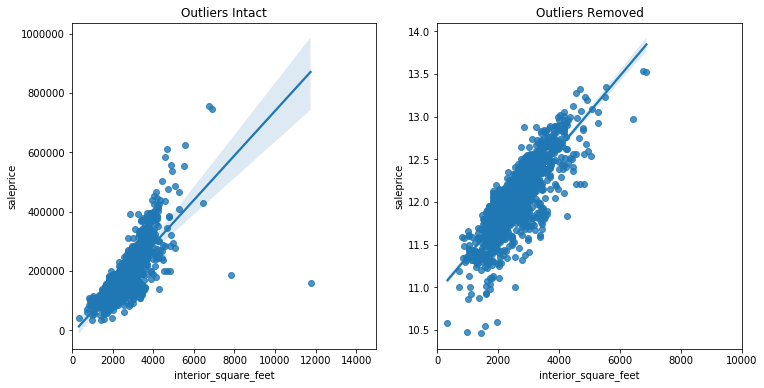

In [25]:
# the two entries in the botom right seem to be obvious outliers. Lets see what removing them does.
tmp = df.drop([523, 1298])

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
x=df['interior_square_feet']
y=df['saleprice']
sns.regplot(x=x, y=y)
plt.xlim(0,15000)
plt.title('Outliers Intact')

plt.subplot(1, 2, 2)
x = tmp['interior_square_feet']
y = np.log(tmp['saleprice'])
sns.regplot(x=x, y=y, data=tmp)
plt.xlim(0,10000)
plt.title('Outliers Removed')

In [ ]:
# The fit is much better especially at higher values

In [26]:
# This increases the correlation of our area variables
tmp.corr()['saleprice'].sort_values(ascending=False)

saleprice               1.000000
interior_square_feet    0.829224
overallqual             0.795863
total_bathrooms         0.635977
garagearea              0.629209
totrmsabvgrd            0.537826
yearremodadd            0.508047
masvnrarea              0.477802
fireplaces              0.469903
outdoor_space           0.427089
lotarea                 0.268174
poolarea                0.099484
mosold                  0.046071
yrsold                 -0.028866
overallcond            -0.078016
kitchenabvgr           -0.135974
age                    -0.523986
Name: saleprice, dtype: float64

### Outliers

As previously noted there are two outliers in the interaction of the target variable and the most strongly correlated continueous variable. There are also several continuous variables that could benefit from transformation. Some of the other variables will be treated by capping their values either just at the upper bound or at both bounds.

In [29]:
# Remove these two outliers in the area/saleprice interaction
df = tmp.copy()

In [30]:
log_list = ['saleprice', 'lotarea']

log_plus_list = ['masvnrarea', 'outdoor_space']

both_bounds = ['interior_square_feet', 'totrmsabvgrd']

upper_bound = ['age', 'total_bathrooms', 'garagearea']

for var in log_list:
    df[var] = np.log(df[var])
    
for var in log_plus_list:
    df[var] = np.log(df[var] + 1)
    
for var in both_bounds:
    df[var] = winsorize(df[var], (0.025, 0.025))

for var in upper_bound:
    df[var] = winsorize(df[var], (0, 0.025))

### Write to file

In [31]:
df.to_csv('houseprices_cleaned.csv', index=False)